In [ ]:
import os, glob
import numpy as np
import matplotlib.pyplot as plt
import warnings
import glob
import subprocess as s
warnings.filterwarnings("ignore")

from astropy.io import fits
from astropy.time import Time
from astropy.table import Table
from scipy.optimize import curve_fit
from copy import deepcopy


fit gaussian to lc

In [ ]:
def plotting(x, y, y_err, model, xlim, ObsID, instrument, figures_path,  xscale='linear', bkg=False):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})
    ax1.tick_params(direction='in', which='both', length=5, labelsize=15)
    ax2.tick_params(direction='in', which='both', length=5, labelsize=15)

    plt.suptitle(instrument)
    
    ax1.set_ylabel(r'N', fontsize = 15.0)
    ax1.set_xscale(xscale)
    
    ax1.set_xlim(0, xlim[1])

    ax1.errorbar(x, y, yerr=y_err, fmt='o', capsize=2, label='Data')
    ax1.plot(x, model, label='Fit')
    ax1.legend(loc='best', fontsize=15.0)

    ax2.set_ylabel(r'Ratio', fontsize = 15.0)
    ax2.set_ylim(0.5,1.5)
    ax2.axhline(y=1.)

    ax2.errorbar(x, y/model, yerr=y_err/model, fmt='o', capsize=2)

    ax2.set_xlabel('Rate [cts/s]', fontsize = 15.0)

    plt.subplots_adjust(hspace=0.1)
    
    plt.show()
def input_lc(fname, path, PN_cts_limit, EMOS_cts_limit):
    os.chdir(path)
    hdul = fits.open(fname)
    data = hdul[1].data
    time = data['time']
    rate = data['rate']
    rate_err = data['error']
    hdul.close()
    # Delete zero rates
    where = np.where(rate == 0)[0]
    time = np.delete(time, where)
    rate = np.delete(rate, where)
    rate_err = np.delete(rate_err, where)
    # filter maximum counts rate before fitting
    if('EPN' in fname or 'Oot' in fname):
        where = np.where(rate > PN_cts_limit)[0]
        time = np.delete(time, where)
        rate = np.delete(rate, where)
        rate_err = np.delete(rate_err, where)
            
    else:
        where = np.where(rate > EMOS_cts_limit)[0]
        time = np.delete(time, where)
        rate = np.delete(rate, where)
        rate_err = np.delete(rate_err, where)
    return rate, time, rate_err, data['rate'], data['time']
def hist_filter(rate):
    # Make histogram
    hist, bin_edges = np.histogram(np.log10(rate), bins=120)
        
    bin_mid = 0.5*(bin_edges[1:] + bin_edges[:-1])
    bin_mid = 10**(bin_mid)
    hist_err = np.sqrt(hist)
    where = np.where(hist_err == 0)[0]
    bin_mid = np.delete(bin_mid, where)
    hist = np.delete(hist, where)
    hist_err = np.delete(hist_err, where)
    return hist, bin_mid, hist_err
def fit_gauss(hist, bin_mid, hist_err):
    # Define gaussian function
    gaussian = lambda x, amp, cen, sig: amp * np.exp(-(x-cen)**2 / sig**2)
    # Fit
    init_vals = [max(hist), np.mean(bin_mid), 0.4]
    best_vals, covar = curve_fit(gaussian, bin_mid, hist, p0=init_vals, sigma=1/hist_err, bounds=((0, 0, 0),
                                                                                        (np.inf, np.inf, np.inf)),
                                maxfev=100000)
    return best_vals[0], best_vals[1], best_vals[2]
def fit_dirty(iter_cts, fname, path, scale, PN_cts_limit=1.5, EMOS_cts_limit=1.5, PLOT=True):
    rate, time, rate_err, rate_ori, time_ori = input_lc(fname, path, PN_cts_limit, EMOS_cts_limit)
    hist, bin_mid, hist_err = hist_filter(rate)
    amp, mu,sigma = fit_gauss(hist, bin_mid, hist_err)
    newrate = deepcopy(rate)
    newtime = deepcopy(time)
    print(newrate.max(), len(newtime))
    for i in range(iter_cts):
        where = (newrate<mu+scale*sigma)&(newrate>mu-scale*sigma)
        newrate = newrate[where]
        newtime = newtime[where]
        hist, bin_mid, hist_err = hist_filter(newrate)
        amp, mu,sigma = fit_gauss(hist, bin_mid, hist_err)
        print(newrate.max(), len(newtime), amp, mu, sigma)
    if PLOT==True:
        gaussian = lambda x, amp, cen, sig: amp * np.exp(-(x-cen)**2 / sig**2)
        plotting(bin_mid, hist, hist_err, gaussian(bin_mid, amp, mu, sigma), 
                    [mu-scale*sigma, mu+scale*sigma], fname, 
                    fname, figures_path='./', bkg=True)
        # check with the original lightcurve data
        plt.figure(figsize = (8,8))
        plt.scatter(newtime,newrate, alpha=0.5, s=2, color = 'b')#, yerr=dat['ERROR'])
        plt.scatter(time_ori,rate_ori, alpha=0.5, s=1, color = 'k')#, yerr=dat['ERROR'])
        plt.axhline(mu+scale*sigma, color = 'r')
        plt.axhline(mu-scale*sigma, color = 'r')
        plt.title(f'{fname}')
        plt.savefig(f'{fname}.png')
    return mu,sigma

imshow the data 

In [ ]:
from astropy.visualization import astropy_mpl_style
import matplotlib.colors as colors
plt.style.use(astropy_mpl_style)
from astropy.utils.data import get_pkg_data_filename
bkg_dir = '/stage/headat/yanling/xmm/fwc_dat'
os.chdir(bkg_dir)

'''
evselect table=mos1_closed_FF_2022_v2_obs201.fits.gz xcolumn=X ycolumn=Y \
imagebinning=binSize ximagebinsize=20 yimagebinsize=20 withimageset=true \
imageset=mos1_closed_FF_2022_v2_obs201.img
'''

image_file = get_pkg_data_filename('mos1_closed_FF_2022_v2_obs201.img')
image_data = fits.getdata(image_file, ext=0)
plt.figure(figsize = (8,8))
plt.imshow(image_data, cmap='binary', norm = colors.LogNorm(vmin = 0.1, vmax = 100))
plt.colorbar()
plt.show()
plt.clf()

# 0. prereduction data

In [ ]:
'''
cd reduction_230227/101
export SAS_CCF=/stage/headat/yanling/xmm/0502020101/ccf.cif
export SAS_ODF=/stage/headat/yanling/xmm/0502020101/1378_0502020101_SCX00000SUM.SAS
emproc
mkdir Main
cd Main
epproc

cd ..
mkdir Oot
cd Oot
epproc withoutoftime=yes

'''
'''
cd 201
export SAS_CCF=/stage/headat/yanling/xmm/0502020201/ccf.cif
export SAS_ODF=/stage/headat/yanling/xmm/0502020201/1380_0502020201_SCX00000SUM.SAS
emproc
cd Main
epproc
cd ..
cd Oot
epproc withoutoftime=yes
'''
import glob
data_dir = '/stage/headat/yanling/xmm/reduction_230227/101'
os.chdir(data_dir)
pn_path = f'{data_dir}/Main'
Oot_path = f'{data_dir}/Oot'

# os.system(f'cp {pn_path}/*_ImagingEvts*.ds .')
# os.system(f'cp {Oot_path}/*_ImagingEvts*.ds 1378_0502020201_Oot_S003_ImagingEvts.ds')


# 1. Extract lc

In [ ]:
'''
We are doing twice cleaning
1. 10-12 keV for mos, 10-14 keV for PN
2. 0.4-1 keV for mos and pn

'''
f = open(f'{data_dir}/data_lc.sh', 'w')
instruments=['EMOS1', 'EMOS2', 'EPN', 'Oot']
energy_bands_1 = [(10, 12), (10,12), (10,14), (10,14)]
energy_bands_2 = [(0.4, 1), (0.4, 1), (0.4, 1), (0.4, 1)]
# energy_bands_2 = [(4, 10), (4, 10), (4, 10), (4, 10)]
for energy_bands in [energy_bands_2]:
    for i, instrument in enumerate(instruments):
        if(instrument == 'EPN') or (instrument =='Oot'):
            ins = 'EP'
            pattern = 4
        else:
            ins = 'EM'
            pattern = 12

        fname = glob.glob(f'*{instrument}*_ImagingEvts.ds')[0]

        print(f'evselect table={fname} withrateset=Y rateset=rate_{int(1000*energy_bands[i][0])}-{int(1000*energy_bands[i][1])}_{instrument}.fits \
maketimecolumn=Y timebinsize=100 makeratecolumn=Y expression="#XMMEA_{ins} && (PI in [{int(1000*energy_bands[i][0])}:{int(1000*energy_bands[i][1])}]) && (PATTERN<={pattern})"')
        f.write(f'evselect table={fname} withrateset=Y rateset=rate_{int(1000*energy_bands[i][0])}-{int(1000*energy_bands[i][1])}_{instrument}.fits \
maketimecolumn=Y timebinsize=100 makeratecolumn=Y expression="#XMMEA_{ins} && (PI in [{int(1000*energy_bands[i][0])}:{int(1000*energy_bands[i][1])}]) && (PATTERN<={pattern})"\n')
f.close()

plot lightcone

In [ ]:
files = ['rate_Oot']

for file in files:
    hdul = fits.open(f'{file}.fits')
    dat = hdul[1].data
    hdul.close()
    plt.figure(figsize = (8,8))
    plt.scatter(dat['TIME'],dat['RATE'])#, yerr=dat['ERROR'])
    # plt.axhline(1.264, color = 'r')
    plt.axhline(0.35, color = 'r')
    plt.title(f'{file}')
    plt.show()

In [ ]:
# show gti
# os.chdir(tmp_dir)
from astropy.io import fits

os.chdir(f'{data_dir}')
hdul = fits.open('EMOS2_gti.fits')
hdul.info()
hdul.close()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
for obs in ['101', '201']:
    fig = plt.subplots(figsize = (8,8))
    data_dir = f'/stage/headat/yanling/xmm/reduction_230227/{obs}'
    os.chdir(data_dir)
    hdul = fits.open('EMOS1_gti_loband.fits')
    dat1 = np.array(hdul[1].data)
    hdul.close()
    hdul = fits.open('EMOS2_gti_loband.fits')
    dat2 = np.array(hdul[1].data)
    hdul.close()
    cb = ['#0173b2', '#de8f05', '#029e73', '#d55e00', '#cc78bc', '#ca9161', '#fbafe4', '#949494', '#ece133', '#56b4e9']

    for j,dat in enumerate([dat1, dat2]):
        for i in range(1,len(dat)):
            plt.hlines(j, dat['START'][i], dat['STOP'][i],color = cb[j], lw=4)
    plt.title(f'obs{obs}')
    plt.legend(loc = 'center right')
    plt.text(np.mean(dat['START']), 0.5, f"MOS1 sumtime: {np.sum(dat1['STOP']-dat1['START'])}")
    plt.text(np.mean(dat['START']), 0.4, f"MOS2 sumtime: {np.sum(dat2['STOP']-dat2['START'])}")


In [ ]:
plt.close()

fit lightcone with gaussian to determine the most stable ctr upper limit

In [ ]:
files = ['EMOS1', 'EMOS2', 'EPN', 'Oot']
for file in files:
    fit(f'rate_{file}.fits', './', PN_cts_limit = 1.3, EMOS_cts_limit = 0.4,)

filter data based on gaussian fit and visual inspect

In [ ]:
from fit_gauss_to_lc import fit_lc_dirty, create_logfile
import datetime
import glob
# Create GTI and filter
instruments = ['EMOS1', 'EMOS2', 'EPN', 'Oot']
energy_bands_1 = [(10, 12), (10,12), (10,14), (10,14)]
energy_bands_2 = [(0.4, 1), (0.4, 1), (0.4, 1), (0.4, 1)]
# energy_bands_2 = [(4, 10), (4, 10), (4, 10), (4, 10)]
scale = [2,2,2,2]
'''
STEP0: extract lightcurves
Generate lightcurve of 10-12 keV, 0.4-1keV for EMOS1, EMOS2. 
Generate lightcurve of 10-14 keV, 0.4-1keV for EPN, Oot.
The time bin is 100s.
-> rate_10000-12000_EMOS*.fits, rate_10000-14000_EPN.fits, rate_10000-14000_Oot.fits, rate_400-1000_EMOS*.fits,

STEP1: clean at high energy range
For 10-12keV (10-14 keV) lightcurve for EMOS (EPN), fit gaussian iteratively until the parameters don't change. 
Visually inspect if the fitting curve and the data look like gaussian, if not, lower the ctr limit and refit.
Finally, for EMOS1 in obs101, limit ctr< 0.3 looks like gaussian. 
-> {inst}_gti_hiband.fits, {inst}_hiband_clean_fov.fits, rate_400-1000_{inst}_hiband_clean.fits

STEP2: clean at low energy range (0.4-1 keV)
-> {inst}_gti_loband.fits, {inst}_hiband_loband_clean_fov.fits

STEP3: calculate exptime after filtered
'''


# firstly filter the gti for high energy band (10-12keV for mos, 10-14keV for pn)

energy_names = ['hiband', 'loband']
os.chdir(f'/stage/headat/yanling/XMM_datareduction')

for obs in ['101', '201']:
    os.system(f'rm log/{datetime.date.today()}/{obs}/*')
    print(obs)
    energy_bands = energy_bands_1
    j = 0
    data_dir = f'/stage/headat/yanling/xmm/reduction_230227/{obs}'
    f1 = open(f'{data_dir}/data_gti_{energy_names[j]}.sh', 'w')
    f2 = open(f'{data_dir}/data_clean_{energy_names[j]}.sh', 'w')
    for i, instrument in enumerate(instruments):
        fname = f'rate_{int(1000*energy_bands[i][0])}-{int(1000*energy_bands[i][1])}_{instrument}.fits'
        # create logger
        os.makedirs(f'log/{datetime.date.today()}/{obs}', exist_ok=True)
        logger = create_logfile('fit_lc_dirty', f'log/{datetime.date.today()}/{obs}/fit_lc_dirty.log')
        logger.info(f'filtering {fname}')
        figpath = f'/stage/headat/yanling/XMM_datareduction/fig/{datetime.date.today()}/{obs}'
        os.makedirs(figpath, exist_ok=True)
        amp, mean, sigma, hist, bin_mid = fit_lc_dirty(25, fname, data_dir, scale[i], 120, logger, figpath = figpath, EMOS_cts_limit=0.3, PLOT=True)
        max_cts = 2*sigma + mean
        print(f'tabgtigen table={fname} expression="RATE<={max_cts}" gtiset={instrument}_gti_{energy_names[j]}.fits')
        f1.write(f'tabgtigen table={fname} expression="RATE<={max_cts}" gtiset={instrument}_gti_{energy_names[j]}.fits\n')      
        fname = glob.glob(f'{data_dir}/*{instrument}*_ImagingEvts.ds')[0]
        fname = fname.split('/')[-1]
        fname2 = f'rate_{int(1000*energy_bands_2[i][0])}-{int(1000*energy_bands_2[i][1])}_{instrument}.fits'
        f2.write(f'evselect table={fname} withfilteredset=Y filteredset={instrument}_{energy_names[j]}_clean.fits destruct=Y keepfilteroutput=T expression="gti({instrument}_gti_{energy_names[j]}.fits,TIME)&&(PI>150)"\n')
        f2.write(f'evselect table={fname2} withfilteredset=Y filteredset={fname2.split(".")[0]}_{energy_names[j]}_clean.fits destruct=Y keepfilteroutput=T expression="gti({instrument}_gti_{energy_names[j]}.fits,TIME)&&(PI>150)"\n')
        if(instrument == 'EPN') or (instrument =='Oot'):
            ins = 'EP'
        else:
            ins = 'EM'
        f2.write(f'evselect table={fname} withfilteredset=Y filteredset={instrument}_{energy_names[j]}_clean_fov.fits destruct=Y keepfilteroutput=T \
expression="##XMMEA_{ins}&&gti({instrument}_gti_{energy_names[j]}.fits,TIME)&&(PI>150)"\n')
        f2.write(f'evselect table={fname2} withfilteredset=Y filteredset={fname2.split(".")[0]}_{energy_names[j]}_clean_fov.fits destruct=Y keepfilteroutput=T \
expression="##XMMEA_{ins}&&gti({instrument}_gti_{energy_names[j]}.fits,TIME)&&(PI>150)"\n')
    f2.close()
    f1.close()
# NOTICE: RUN data_gti_hiband.sh  & data_clean_hiband.sh in 101 and 201 dir first then run the following
# then further filter the gti previously filtered gti for lower broad energy band (4-10 keV for mos and pn)
    energy_bands = energy_bands_2
    j = 1
    data_dir = f'/stage/headat/yanling/xmm/reduction_230227/{obs}'
    scale = [2,2,2,2]
    f1 = open(f'{data_dir}/data_gti_{energy_names[j]}.sh', 'w')
    f2 = open(f'{data_dir}/data_clean_{energy_names[j]}.sh', 'w')
    for i, instrument in enumerate(instruments):
        fname = f'rate_{int(1000*energy_bands[i][0])}-{int(1000*energy_bands[i][1])}_{instrument}_hiband_clean.fits'
        # create logger
        logger = create_logfile('fit_lc_dirty', f'log/{datetime.date.today()}/{obs}/fit_lc_dirty_loband.log')
        logger.info(f'filtering {fname}')
        figpath = f'/stage/headat/yanling/XMM_datareduction/fig/{datetime.date.today()}/{obs}'
        os.makedirs(figpath, exist_ok=True)
        amp, mean, sigma, hist, bin_mid = fit_lc_dirty(25, fname, data_dir, scale[i], 120, logger, figpath = figpath, PN_cts_limit=3, EMOS_cts_limit=0.6, PLOT=True)
        max_cts = 2*sigma + mean
        print(f'tabgtigen table={fname} expression="RATE<={max_cts}" gtiset={instrument}_gti_{energy_names[j]}.fits')
        f1.write(f'tabgtigen table={fname} expression="RATE<={max_cts}" gtiset={instrument}_gti_{energy_names[j]}.fits\n')      
        fname = f'{instrument}_hiband_clean_fov.fits'
        
        if(instrument == 'EPN') or (instrument =='Oot'):
            ins = 'EP'
        else:
            ins = 'EM'
        f2.write(f'evselect table={fname} withfilteredset=Y filteredset={instrument}_hiband_{energy_names[j]}_clean_fov.fits destruct=Y keepfilteroutput=T expression="##XMMEA_{ins}&&gti({instrument}_gti_{energy_names[j]}.fits,TIME)&&(PI>150)"\n')
    f2.close()
    f1.close()

In [ ]:
sh data_gti_hiband.sh
sh data_clean_hiband.sh
sh data_gti_loband.sh
sh data_clean_loband.sh

# 2. Extract image

In [ ]:
import glob
import datetime
for obs in ['101', '201']:
    data_dir = f'/stage/headat/yanling/xmm/reduction_230227/{obs}'
    os.chdir(data_dir)
    # os.system(f'export SAS_CCF=/stage/headat/yanling/xmm/0502020{obs}/ccf.cif')
    # os.system(f'export SAS_ODF=/stage/headat/yanling/xmm/0502020{obs}/*SUM.SAS')
    f = open('data_img_allbands.sh', 'w')

    instruments = ['EMOS1', 'EMOS2', 'EPN', 'Oot']
    for instrument in instruments:
        for band in ['700-1200', '1200-2000', '2000-5000', '5000-7000']:
            blo = band.split('-')[0]
            bhi = band.split('-')[1]
            if(instrument == 'EPN')or (instrument =='Oot'):
                ins = 'EP'
                pattern = 4
                
            else:
                ins = 'EM'
                pattern = 12
                
            # Create image
            fname = instrument + '_hiband_loband_clean_fov.fits'
            f.write(f'evselect table={fname} xcolumn=X ycolumn=Y imagebinning=binSize ximagebinsize=80 \
yimagebinsize=80 withimageset=true imageset={instrument}_counts_nr_{blo}-{bhi}_{datetime.date.today()}.img expression="#XMMEA_{ins}&&(PATTERN<={pattern})&&(PI in [{blo}:{bhi}])"\n')
            
            # Create exposure map
            fname = glob.glob('*_AttHk.ds')[0]
            f.write(f'eexpmap imageset={instrument}_counts_nr_{blo}-{bhi}_{datetime.date.today()}.img attitudeset={fname} eventset={instrument}_hiband_loband_clean_fov.fits \
expimageset={instrument}_exp_nr_{blo}-{bhi}_{datetime.date.today()}.img pimin={blo} pimax={bhi}\n')
            # note: no expmap for oot
    f.close()
    # os.system(f'sh data_img_allbands.sh') # can't 



manage pn image (substract oot data)

In [ ]:
for obs in ['101', '201']:
    data_dir = f'/stage/headat/yanling/xmm/reduction_230227/{obs}'
    os.chdir(data_dir)
    f = open(f'data_pn_corr_bands.sh', 'w')
    for band in ['700-1200', '1200-2000', '2000-5000', '5000-7000']:
        frame = 'eff'
        # Scale OoT image
        if(frame == 'eff'):
            f.write(f'farith Oot_counts_nr_{band}_{datetime.date.today()}.img 0.023 Oot_rescaled_counts_{band}_{datetime.date.today()}.img MUL clobber=yes \n')
        elif(frame == 'ff'):
            f.write(f'farith Oot_counts_nr_{band}_{datetime.date.today()}.img 0.063 Oot_rescaled_counts_{band}_{datetime.date.today()}.img MUL clobber=yes \n')
        f.write(f'farith EPN_counts_nr_{band}_{datetime.date.today()}.img Oot_rescaled_counts_{band}_{datetime.date.today()}.img EPN_corr_counts_nr_{band}_{datetime.date.today()}.img SUB clobber=yes \n')
    f.close()

filter bkg events by gaussian filtering gti

In [ ]:
from fit_gauss_to_lc import fit_lc_dirty, create_logfile
bkg_dir = '/stage/headat/yanling/xmm/fwc_dat'
os.chdir(bkg_dir)
figpath = f'/stage/headat/yanling/XMM_datareduction/fig/{datetime.date.today()}/bkg'
os.makedirs(figpath, exist_ok=True)

files = ['mos1_closed_FF_2022_v2', 'mos2_closed_FF_2022_v2', 'pn_closed_EFF_2022_v2', 'pn_closed_EFF_oot_2022_v2']
scale = [2,2,2,2]
insts = ['EMOS1', 'EMOS2', 'EPN', 'Oot']
f1 = open('bkg_gti.sh', 'w')
f2 = open('bkg_clean.sh', 'w')
for i, file in enumerate(files):    
        # Create GTI and filter
        fname = f'rate_{file}_bkg.fits'
        os.makedirs(f'/stage/headat/yanling/XMM_datareduction/log/{datetime.date.today()}/bkg', exist_ok=True)
        logger = create_logfile('fit_lc_dirty_bkg', f'/stage/headat/yanling/XMM_datareduction/log/{datetime.date.today()}/bkg/fit_lc_dirty.log')
        amp, mean, sigma, hist, bin_mid = fit_lc_dirty(25, fname, bkg_dir, scale[i], 1200, logger, PN_cts_limit = 100, EMOS_cts_limit = 100, PLOT=False)
        f1.write(f'tabgtigen table={fname} expression="RATE<={mean+2*sigma}" gtiset={insts[i]}_bkg_gti_{datetime.date.today()}.fits\n')
        f2.write(f'evselect table={file}.fits.gz withfilteredset=Y filteredset={insts[i]}_bkg_clean_{datetime.date.today()}.fits destruct=Y \
keepfilteroutput=T expression="gti({insts[i]}_bkg_gti_{datetime.date.today()}.fits,TIME)&&(PI>150)"\n')
f2.close()
f1.close()
                

generate scaled bkg images

In [ ]:
import datetime
# reproject bkg events


bkg_dir = '/stage/headat/yanling/xmm/fwc_dat'
os.chdir(bkg_dir)
f = open(f'{bkg_dir}/bkg_reproj_evt.sh', 'w')
files = ['mos1_closed_FF_2022_v2', 'mos2_closed_FF_2022_v2', 'pn_closed_EFF_2022_v2', 'pn_closed_EFF_oot_2022_v2']
insts = ['EMOS1', 'EMOS2', 'EPN', 'Oot']

ralist = [24.409, 24.429]
declist = [-12.943, -12.870]
palist = [59.440, 60.977]

for j in range(2):
        obs = f'{j+1}01'
        ra = ralist[j]; dec = declist[j]; pa = palist[j]
        for i in range(len(insts)):
                f.write(f'cp {insts[i]}_bkg_clean_{datetime.date.today()}.fits {insts[i]}_obs{obs}_bkg_clean_{datetime.date.today()}.fits\n')
                f.write(f'evproject eventset={insts[i]}_obs{obs}_bkg_clean_{datetime.date.today()}.fits attsource=fixed attra={ra} attdec={dec} attapos={pa}\n')

f.close()


# extract and scale the bkg images
bkg_dir = '/stage/headat/yanling/xmm/fwc_dat'
os.chdir(bkg_dir)
# files = ['mos1_closed_FF_2022_v2', 'mos2_closed_FF_2022_v2', 'pn_closed_EFF_2022_v2', 'pn_closed_EFF_oot_2022_v2']
scales_dir = {'101':[0.02684542, 0.02770809, 0.02605008, 0.02399071], 
    '201':[0.02864311, 0.02867754, 0.04227544, 0.04520831]}

for obs in [101, 201]:
    for band in ['700-1200', '1200-2000', '2000-5000', '5000-7000']:
        blo = band.split('-')[0]
        bhi = band.split('-')[1]

        scales = scales_dir[str(obs)]
        f = open(f'{bkg_dir}/bkg_img_obs{obs}_{blo}-{bhi}.sh', 'w')
        for i, file in enumerate(insts):
            evtfile = f'{file}_obs{obs}_bkg_clean_{datetime.date.today()}'
            imgfile = f'{evtfile}_{blo}-{bhi}'
#             if ('PN' in file):
#                 ins = 'EP'
#                 pattern = 4
#                 f.write(f'evselect table={evtfile}.fits xcolumn=X ycolumn=Y imagebinning=binSize ximagebinsize=80 \
# yimagebinsize=80 withimageset=true imageset={imgfile}.img expression="#XMMEA_{ins}&&(PATTERN<={pattern})&&(PI>={blo})&&(PI<={bhi})"\n')
                
#             elif 'MOS' in file:
#                 ins = 'EM'
#                 pattern = 12
#                 f.write(f'evselect table={evtfile}.fits xcolumn=X ycolumn=Y imagebinning=binSize ximagebinsize=80 \
# yimagebinsize=80 withimageset=true imageset={imgfile}.img expression="#XMMEA_{ins}&&(PATTERN<={pattern})&&(PI>={blo})&&(PI<={bhi})&&(CCDNR.ne.6)"\n')
            if 'Oot' in file:
                ins = 'EP'
                pattern = 4
                f.write(f'evselect table={evtfile}.fits xcolumn=X ycolumn=Y imagebinning=binSize ximagebinsize=80 \
yimagebinsize=80 withimageset=true imageset={imgfile}.img expression="#XMMEA_{ins}&&(PATTERN<={pattern})&&(PI>={blo})&&(PI<={bhi})"\n')
            
            f.write(f'farith {imgfile}.img {scales[i]} {imgfile}_scaled.img "*" clobber=yes\n')
        f.close()

manage PN images

In [ ]:
bkg_dir = '/stage/headat/yanling/xmm/fwc_dat'
os.chdir(bkg_dir)
f = open('bkg_pn_oot_corr.sh', 'w')
for band in ['700-1200', '1200-2000', '2000-5000', '5000-7000']:
      blo = band.split('-')[0]
      bhi = band.split('-')[1]
      frame = 'eff'
      # Scale OoT image
      for obs in [101,201]:
            pn_imgname = f'EPN_obs{obs}_bkg_clean_{datetime.date.today()}_{blo}-{bhi}_scaled'
            oot_imgname = f'Oot_obs{obs}_bkg_clean_{datetime.date.today()}_{blo}-{bhi}_scaled'
            if(frame == 'eff'):
                  print(f'farith {oot_imgname}.img 0.023 {oot_imgname}_corr.img MUL clobber=yes')
                  f.write(f'farith {oot_imgname}.img 0.023 {oot_imgname}_corr.img MUL clobber=yes\n')
                  
            elif(frame == 'ff'):
                  print(f'farith {oot_imgname}.img 0.063 {oot_imgname}_corr.img MUL clobber=yes')
                  f.write(f'farith {oot_imgname}.img 0.063 {oot_imgname}_corr.img MUL clobber=yes\n')

            print(f'farith {pn_imgname}.img {oot_imgname}_corr.img {pn_imgname}_corr.img SUB clobber=yes')
            f.write(f'farith {pn_imgname}.img {oot_imgname}_corr.img {pn_imgname}_corr.img SUB clobber=yes\n')
f.close()

check the images

(648, 648)


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 59363.047164 from DATE-OBS.
Set MJD-END to 59363.122049 from DATE-END'. [astropy.wcs.wcs]
<ipython-input-16-710b0af26e5c>:26: RuntimeWarning: divide by zero encountered in log10
  image_data = np.where(np.isfinite(np.log10(image_data)), image_data, np.nan)
<ipython-input-16-710b0af26e5c>:26: RuntimeWarning: invalid value encountered in log10
  image_data = np.where(np.isfinite(np.log10(image_data)), image_data, np.nan)


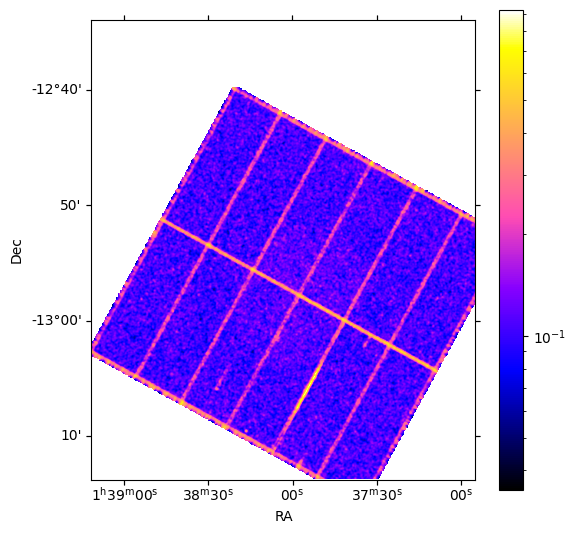

<Figure size 640x480 with 0 Axes>

In [16]:
# from astropy.visualization import astropy_mpl_style
import matplotlib.colors as colors
import matplotlib.pyplot as plt
# plt.style.use(astropy_mpl_style)
plt.style.use('default')
from astropy.utils.data import get_pkg_data_filename
from astropy.wcs import WCS
from astropy.convolution import convolve
from astropy.convolution import Gaussian2DKernel
from astropy.io import fits
import numpy as np
kernel = Gaussian2DKernel(x_stddev=1)
# 'EPN_corr_counts'
file = f"{bkg_dir}/EPN_obs201_bkg_clean_2023-05-04_1200-2000_scaled_corr"
hdu = fits.open(f'{file}.img')[0]
image_data = hdu.data
print(image_data.shape)
fig = plt.figure(figsize = (6,6))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection=WCS(f'{file}.img'))
ra = ax.coords[0]
dec = ax.coords[1]
# plt.grid(color='grey', ls='dashed')
plt.grid('off')
ra.set_axislabel('RA')
dec.set_axislabel('Dec')
image_data = np.where(np.isfinite(np.log10(image_data)), image_data, np.nan)
astropy_conv = convolve(image_data, kernel)
plt.imshow(astropy_conv[50:650,50:550], cmap='gnuplot2', norm = colors.LogNorm(), origin='lower')
plt.colorbar()
plt.savefig(f'{file}.png')
plt.show()
plt.clf()


# 3. emosaic image and bkg images, and substract image with bkg 

remember to generate bkg images for new energy bands in xmm_bkg_extraction.ipynb!

In [17]:
workdir = '/stage/headat/yanling/xmm/reduction_230227/merged'
os.makedirs(workdir, exist_ok=True)
os.chdir(workdir)
for obs in [101, 201]:
        for band in ['700-1200', '1200-2000', '2000-5000', '5000-7000']:
                os.system(f'cp /stage/headat/yanling/xmm/fwc_dat/EMOS1_v2_obs{obs}_bkg_clean_{datetime.date.today()}_{band}_scaled.img .')
                os.system(f'cp /stage/headat/yanling/xmm/fwc_dat/EMOS2_obs{obs}_bkg_clean_{datetime.date.today()}_{band}_scaled.img .')
                os.system(f'cp /stage/headat/yanling/xmm/fwc_dat/EPN_obs{obs}_bkg_clean_{datetime.date.today()}_{band}_scaled_corr.img .')

                os.system(f'cp /stage/headat/yanling/xmm/reduction_230227/{obs}/EMOS1_counts_nr_{band}_{datetime.date.today()}.img EMOS1_counts_obs{obs}_{band}_{datetime.date.today()}.img')
                os.system(f'cp /stage/headat/yanling/xmm/reduction_230227/{obs}/EMOS2_counts_nr_{band}_{datetime.date.today()}.img EMOS2_counts_obs{obs}_{band}_{datetime.date.today()}.img')
                os.system(f'cp /stage/headat/yanling/xmm/reduction_230227/{obs}/EPN_corr_counts_nr_{band}_{datetime.date.today()}.img EPN_counts_obs{obs}_{band}_{datetime.date.today()}.img')

                os.system(f'cp /stage/headat/yanling/xmm/reduction_230227/{obs}/EMOS1_exp_nr_{band}_{datetime.date.today()}.img EMOS1_exp_obs{obs}_{band}_{datetime.date.today()}.img')
                os.system(f'cp /stage/headat/yanling/xmm/reduction_230227/{obs}/EMOS2_exp_nr_{band}_{datetime.date.today()}.img EMOS2_exp_obs{obs}_{band}_{datetime.date.today()}.img')
                os.system(f'cp /stage/headat/yanling/xmm/reduction_230227/{obs}/EPN_exp_nr_{band}_{datetime.date.today()}.img EPN_exp_obs{obs}_{band}_{datetime.date.today()}.img')


merge btw instruments

In [ ]:
f = open(f'img_merge_obs_bands.sh' , 'w')
for band in ['700-1200', '1200-2000', '2000-5000', '5000-7000',]:    
    datas = f'EMOS1_counts_obs101_{band}.img EMOS1_counts_obs201_{band}.img'
    exps = f'EMOS1_exp_obs101_{band}.img EMOS1_exp_obs201_{band}.img'
    bkgs = f'mos1_closed_FF_2022_v2_obs101_bkg_clean_{band}_scaled.img mos1_closed_FF_2022_v2_obs201_bkg_clean_{band}_scaled.img'
    print(f'emosaic imagesets="{datas}" mosaicedset=EMOS1_cts_{band}.img withexposure=no')
    print(f'emosaic imagesets="{exps}" mosaicedset=EMOS1_exp_{band}.img withexposure=no')
    print(f'emosaic imagesets="{bkgs}" mosaicedset=EMOS1_bkg_{band}.img withexposure=no')
    f.write(f'emosaic imagesets="{datas}" mosaicedset=EMOS1_cts_{band}.img withexposure=no\n')
    f.write(f'emosaic imagesets="{exps}" mosaicedset=EMOS1_exp_{band}.img withexposure=no\n')
    f.write(f'emosaic imagesets="{bkgs}" mosaicedset=EMOS1_bkg_{band}.img withexposure=no\n')

    datas = f'EMOS2_counts_obs101_{band}.img EMOS2_counts_obs201_{band}.img'
    exps = f'EMOS2_exp_obs101_{band}.img EMOS2_exp_obs201_{band}.img'
    bkgs = f'mos2_closed_FF_2022_v2_obs101_bkg_clean_{band}_scaled.img mos2_closed_FF_2022_v2_obs201_bkg_clean_{band}_scaled.img'
    print(f'emosaic imagesets="{datas}" mosaicedset=EMOS2_cts_{band}.img withexposure=no')
    print(f'emosaic imagesets="{exps}" mosaicedset=EMOS2_exp_{band}.img withexposure=no')
    print(f'emosaic imagesets="{bkgs}" mosaicedset=EMOS2_bkg_{band}.img withexposure=no')
    f.write(f'emosaic imagesets="{datas}" mosaicedset=EMOS2_cts_{band}.img withexposure=no\n')
    f.write(f'emosaic imagesets="{exps}" mosaicedset=EMOS2_exp_{band}.img withexposure=no\n')
    f.write(f'emosaic imagesets="{bkgs}" mosaicedset=EMOS2_bkg_{band}.img withexposure=no\n')

    datas = f'EPN_counts_obs101_{band}.img EPN_counts_obs201_{band}.img'
    exps = f'EPN_exp_obs101_{band}.img EPN_exp_obs201_{band}.img'
    bkgs = f'pn_closed_EFF_2022_v2_obs101_bkg_clean_{band}_scaled_corr.img pn_closed_EFF_2022_v2_obs201_bkg_clean_{band}_scaled_corr.img'
    print(f'emosaic imagesets="{datas}" mosaicedset=EPN_cts_{band}.img withexposure=no')
    print(f'emosaic imagesets="{exps}" mosaicedset=EPN_exp_{band}.img withexposure=no')
    print(f'emosaic imagesets="{bkgs}" mosaicedset=EPN_bkg_{band}.img withexposure=no')
    f.write(f'emosaic imagesets="{datas}" mosaicedset=EPN_cts_{band}.img withexposure=no\n')
    f.write(f'emosaic imagesets="{exps}" mosaicedset=EPN_exp_{band}.img withexposure=no\n')
    f.write(f'emosaic imagesets="{bkgs}" mosaicedset=EPN_bkg_{band}.img withexposure=no\n')
f.close()

emosaic all images

In [ ]:
workdir = '/stage/headat/yanling/xmm/reduction_230227/merged'
os.chdir(workdir)
f = open('img_merge_all_bands.sh' , 'w')
for band in ['700-1200', '1200-2000', '2000-5000', '5000-7000',]:
    datas = f'EMOS1_cts_{band}.img EMOS2_cts_{band}.img EPN_cts_{band}.img'
    exps = f'EMOS1_exp_{band}.img EMOS2_exp_{band}.img EPN_exp_{band}.img'
    bkgs = f'EMOS1_bkg_{band}.img EMOS2_bkg_{band}.img EPN_bkg_{band}.img'

    print(f'emosaic imagesets="{datas}" mosaicedset=EPIC_cts_{band}.img withexposure=no')
    print(f'emosaic imagesets="{exps}" mosaicedset=EPIC_exp_{band}.img withexposure=no')
    print(f'emosaic imagesets="{bkgs}" mosaicedset=EPIC_bkg_{band}.img withexposure=no')
    f.write(f'emosaic imagesets="{datas}" mosaicedset=EPIC_cts_{band}.img withexposure=no\n')
    f.write(f'emosaic imagesets="{exps}" mosaicedset=EPIC_exp_{band}.img withexposure=no\n')
    f.write(f'emosaic imagesets="{bkgs}" mosaicedset=EPIC_bkg_{band}.img withexposure=no\n')
f.close()

subtract bkg

In [ ]:
# data-bkg
instruments = ['EMOS1', 'EMOS2', 'EPN']
workdir = '/stage/headat/yanling/xmm/reduction_230227/merged'
os.chdir(workdir)
f = open('data_sub_bkg.sh', 'w')
for ins in instruments:
    for band in ['700-1200', '1200-2000', '2000-5000', '5000-7000',]:
        blo = band.split('-')[0]
        bhi = band.split('-')[1]
        f.write(f'farith {ins}_cts_{blo}-{bhi}.img {ins}_bkg_{blo}-{bhi}.img {ins}_net_{blo}-{bhi}.img "-" clobber=yes\n')
        f.write(f'farith {ins}_net_{blo}-{bhi}.img {ins}_exp_{blo}-{bhi}.img {ins}_net_ctr_{blo}-{bhi}.img "/" clobber=yes\n')
f.close()

only merge mos1, mos2

In [ ]:
workdir = '/stage/headat/yanling/xmm/reduction_230227/merged'
os.chdir(workdir)
for band in ['5000-7000']:
    blo = band.split('-')[0]
    bhi = band.split('-')[1]
    f = open(f'img_merge_mos_{blo}-{bhi}.sh' , 'w')
    datas = f'EMOS1_cts_{blo}-{bhi}.img EMOS2_cts_{blo}-{bhi}.img'
    exps = f'EMOS1_exp_{blo}-{bhi}.img EMOS2_exp_{blo}-{bhi}.img'
    bkgs = f'EMOS1_bkg_{blo}-{bhi}.img EMOS2_bkg_{blo}-{bhi}.img'

    print(f'emosaic imagesets="{datas}" mosaicedset=EMOS_cts_{blo}-{bhi}.img withexposure=no')
    print(f'emosaic imagesets="{exps}" mosaicedset=EMOS_exp_{blo}-{bhi}.img withexposure=no')
    print(f'emosaic imagesets="{bkgs}" mosaicedset=EMOS_bkg_{blo}-{bhi}.img withexposure=no')
    f.write(f'emosaic imagesets="{datas}" mosaicedset=EMOS_cts_{blo}-{bhi}.img withexposure=no\n')
    f.write(f'emosaic imagesets="{exps}" mosaicedset=EMOS_exp_{blo}-{bhi}.img withexposure=no\n')
    f.write(f'emosaic imagesets="{bkgs}" mosaicedset=EMOS_bkg_{blo}-{bhi}.img withexposure=no\n')
    f.close()

# 5. wavdetect xmm

create fov image

In [ ]:
f = open('gen_fov.sh', 'w')
instruments = ['EPIC']
for ins in instruments:
    print(f'dmimgcalc {ins}_net.img none {ins}_psf.fits op="imgout=((img1*0)+9.0)" clobber=yes')
    f.write(f'dmimgcalc {ins}_net.img none {ins}_psf.fits op="imgout=((img1*0)+9.0)" clobber=yes\n')
    print(f'dmhedit {ins}_psf.fits none add BUNIT "arcsec"')
    f.write(f'dmhedit {ins}_psf.fits none add BUNIT "arcsec"\n')

f.close()


perform wavdetect

In [ ]:
workdir = '/stage/headat/yanling/xmm/reduction_230227/merged'
instruments = ['EPIC']
sigthresh = 2e-6

os.makedirs(f'{workdir}/wavdetect_sig{sigthresh}', exist_ok = True)
os.chdir(f'{workdir}/wavdetect_sig{sigthresh}')
f = open(f'wavdetect.sh', 'w')
for ins in instruments:
    print(f'punlearn wavdetect')
    f.write(f'punlearn wavdetect')
    print(f'wavdetect infile=../{ins}_net.img outfile={ins}_src.fits scellfile={ins}_scell.fits imagefile={ins}_imgfile.fits expfile=../{ins}_exp.img defnbkgfile={ins}_nbgd.fits regfile={ins}_src.reg scales="1.0 2.0 4.0" clobber=yes ellsigma=4 sigthresh={sigthresh} psffile=../{ins}_psf.fits ')
    f.write(f'wavdetect infile=../{ins}_net.img outfile={ins}_src.fits scellfile={ins}_scell.fits imagefile={ins}_imgfile.fits expfile=../{ins}_exp.img defnbkgfile={ins}_nbgd.fits regfile={ins}_src.reg scales="1.0 2.0 4.0" clobber=yes ellsigma=4 sigthresh={sigthresh} psffile=../{ins}_psf.fits ')
f.close()

perform emldetect

In [ ]:
likelihood=6

run srcflux

1. define bkg regions 

In [ ]:
#streak region is a random circle region out of fov
os.chdir('/stage/headat/yanling/xmm/reduction_230227/merged/wavdetect')
instruments = ['EPN', 'EMOS1', 'EMOS2']
for ins in instruments:
    os.makedirs(f'./rui_src', exist_ok=True)
    print(f'roi infile=srclist_sum_ex_extend_byeye.fits outsrc="rui_src/src%d.fits" radiusmode=mul bkgradius=2 group=individual fovregion="region({ins}_fov.reg)" streakregion="circle(572,650,34)"')

combine regions from fits files in reg file and check

In [ ]:
workdir = '/stage/headat/yanling/xmm/reduction_230227/merged/wavdetect'
for ins in instruments:
    f1 = open(f'{workdir}/{ins}_allsrc_individual.reg', 'w')
    f2 = open(f'{workdir}/{ins}_allbkg_individual.reg', 'w')
    f1.write('physical\n')
    f2.write('physical\n')
    reglists = glob.glob(f'{workdir}/{ins}_src_regions_individual/src*.fits')
    for reg in reglists:
        hdul = fits.open(reg)
        l = hdul['SRCREG'].data
        for i in range(len(l['X'])):
            f1.write(f"ellipse({l['X'][i]},{l['Y'][i]},{l['R'][i][0]},{l['R'][i][1]},{l['ROTANG'][i][0]})\n")
        l = hdul['BKGREG'].data
        i = 0
        f2.write(f"ellipse({l['X'][i]},{l['Y'][i]},{l['R'][i][0]},{l['R'][i][1]},{l['ROTANG'][i][0]})\n")
        for i in range(1,len(l['X'])):
            f2.write(f"-ellipse({l['X'][i]},{l['Y'][i]},{l['R'][i][0]},{l['R'][i][1]},{l['ROTANG'][i][0]})\n")
    f1.close()
    f2.close()

In [ ]:
# 在 vim 中删掉有nan 的行
# 删掉两个 cluster
# -> edited.reg

In [ ]:
for ins in instruments:
    f1 = open(f'{ins}_src.lis', 'w')
    f2 = open(f'{ins}_bkg.lis', 'w')
    reglists = glob.glob(f'{workdir}/{ins}_src_regions_individual/src*.fits')
    for i in range(len(reglists)):
        f1.write(f'{ins}_src_regions_individual/src{i+1}.fits["SRCREG"]\n')
        f2.write(f'{ins}_src_regions_individual/src{i+1}.fits["BKGREG"]\n')
    f1.close()
    f2.close()

run srcflux !srcflux can't run XMM dataset!

In [ ]:

for ins in instruments:
    os.makedirs(f'{workdir}/{ins}_srcflux', exist_ok=True)
    print('punlearn srcflux')
    print(f'srcflux infile=../../../101/{ins}_clean.fits pos=../../{ins}_src.fits outroot=srcflux bands=2.0:8.0:3.8 srcreg=@../{ins}_src.lis bkgreg=@../{ins}_bkg.lis psfmethod=ideal model="xstbabs.abs1*xspowerlaw.pow1" paramvals="pow1.PhoIndex=1.4" absmodel="xstbabs.abs1" absparams="abs1.nH=1.62e-20" abund=lodd clobber=yes')

use wavdetect to briefly estimate detection limit of point sources

In [ ]:
workdir = '/stage/headat/yanling/xmm/reduction_230227/merged'
hdul = fits.open(f'{workdir}/wavdetect_sig1e-06/EPIC_src.fits')
# path = '/stage/headat/yanling/chandra/chandra/data/wavdetect_232223'
# hdul = fits.open(f'{path}/wavdetect_merge_clean_withexp_src.fits')
dat = hdul[1].data
plt.hist(dat['NET_RATE'], np.logspace(-4,-1,20))
plt.xscale('log')
plt.yscale('log')
plt.axvline(5E-4, color='r')
plt.show()
print(len(dat['NET_RATE']), dat['NET_RATE'].max())
print(np.arange(len(dat['NET_RATE']))[dat['NET_RATE']> 0.8e-6])
print(len(np.arange(len(dat['NET_RATE']))[dat['NET_RATE']> 0.8e-6]))

exclude the src reg list via histogram above

In [ ]:
path = '/stage/headat/yanling/xmm/reduction_230227/merged/wavdetect_sig1e-06'
newf = open(f'{path}/EPIC_src_ctr5e-3.reg', 'w')
f = open(f'{path}/EPIC_src.reg')
hdul = fits.open(f'{path}/EPIC_src.fits')
dat = hdul[1].data
lines = f.readlines()
f.close()
lines = np.array(lines)[dat['NET_RATE']>5e-3]
for line in lines:
    newf.write(line)
newf.close()

create suzaku point source regions based on this (run locally)

In [ ]:
path = '.'
f = open(f'{path}/EPIC_src_ctr1e-3_fk5.reg')
newf = open(f'{path}/EPIC_src_ctr1e-3_fk5_suzaku_9am.reg','w')
lines = f.readlines()[3:]
f.close()
newf.write('fk5\n')
for line in lines:
    ra = line.split('(')[-1].split(',')[0]
    dec = line.split('(')[-1].split(',')[1]
    newf.write(f"circle({ra},{dec},0.9')\n")
newf.close()